# Sensitivity analysis

Let $\vec{M}(\vec{\theta})$ be a model parameterized by parameters $\vec{\theta}$ which belong to a parameter space $\vec{\Theta}\subset\mathbb{R}^k$. Among all possible methods for computing the total sensitivity index (which quantifies all effects of the parameter on the model output), we have selected the techniques presented in Saltelli 2010 due to their efficient convergence with smaller sample sizes compared to other approaches. Initially, we construct two $N\times K$ matrices, $\mathbf{A}$ and $\mathbf{B}$, where $K$ is the number of parameters, and $N$ is the sample size. In these matrices, $N$ random samples are drawn from a uniform distribution corresponding to the range of each parameters' uncertainty. Each row of these matrices represents a sampled value for the vector of parameter $\vec{\theta}$. Additionally, $K$ matrices $\mathbf{A}_{\mathbf{B}}^{(k)}, \; k=1,2, \cdots, K$, are defined where all columns are from $\mathbf{A}$ except the $k^{th}$ column, which comes from $\mathbf{B}$. The model outputs are then evaluated for each row of the matrices $\mathbf{A}$ and $\mathbf{A}_{\mathbf{B}}^{(k)}$ and the outputs are stored in the vectors $\boldsymbol{Y}_{\boldsymbol{A}}$ and $\boldsymbol{Y}_{\boldsymbol{A}\boldsymbol{B}}^{(k)}$. Finally, the post processing of theses results consists of computing the total sensitivity index, $S_{T_k}$, for each parameter $k$. The total effect, $S_{T_k}$, measures the contribution of the input $\theta_k$ to the model output variation. The total-effect index for each parameter, $\{S_{T_k}\}_{k=1}^K$, can be approximated using the following estimator,
\begin{equation}
S_{T_k} \approx \frac{1}{2N}\sum_{j=1}^{N}\left(\left(\boldsymbol{Y}_{\boldsymbol{A}}\right)_j-\left(\boldsymbol{Y}_{\boldsymbol{A}\boldsymbol{B}}^{(k)}\right)_j\right)^2.
\end{equation}

By employing the algorithm outlined above, we can estimate multi-dimensional integrals with just $N(K+1)$ model evaluations, significantly reducing computational costs. For time-dependent processes, we repeat these steps for each time step to capture the importance of each model parameter over time.

Saltelli, Andrea, Paola Annoni, Ivano Azzini, Francesca Campolongo, Marco Ratto, and Stefano Tarantola. "Variance based sensitivity analysis of model output. Design and estimator for the total sensitivity index." Computer physics communications 181, no. 2 (2010): 259-270.

We are computing the sensitivity analysis of the following model:
\begin{align}
\frac{dT}{dt}=rT\left(1-\frac{T}{K}\right)-\alpha T\sum_{i=1}^{N_i}e^{-\beta(t-\tau_i)}H(t-\tau_i),
\end{align}
- $T$: tumor volume;
- $r$: tumor growth rate;
- $K$: carrying capacity;
- $\alpha$: death rate due to treatment;
- $\beta$: control the duration of the treatment effects;
- $\tau_i$: day of treatment $i$.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from string import ascii_uppercase
#displayDir = '../../Displays/SensitivityAnalysis/';
displayDir = '../../Displays/Manuscript/Figures/'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 'stix' or 'stixsans' provides Times-like fonts for math
plt.rcParams['font.size'] = 16

def generate_samples(parameters, samples=100000):
    """
    Generate and manipulate sample matrices for sensitivity analysis.

    Parameters:
    - parameters (int): The number of parameters, indicating the columns in sample matrices A and B.
    - samples (int, optional): The number of samples or rows in the matrices (default is 100000).

    Returns:
    - list: A list containing three elements:
      - A (numpy.ndarray): Matrix A with random values.
      - B (numpy.ndarray): Matrix B with random values.
      - C (numpy.ndarray): A three-dimensional array where each slice C[c] is a modified matrix C based on A and B.

    Note:
    This function generates random sample matrices A and B and manipulates them to create a three-dimensional array C.
    The parameter values range from 0 to 1. You will need to scale them.
    """
    # Set a random seed for reproducibility (optional, can be adjusted or omitted).
    np.random.seed(2023)

    # Generate two random sample matrices, A and B, with 'samples' rows and 'parameters' columns.
    A = np.random.rand(samples, parameters)
    B = np.random.rand(samples, parameters)

    # Create a three-dimensional array C to store multiple modified matrices.
    C = np.empty((parameters, samples, parameters))

    # Loop through the parameter columns to create modified matrices for C.
    for c in range(parameters):
        # Make a copy of matrix A to ensure no data is shared between A and C.
        C[c] = A.copy()

        # Replace the 'c' column of each slice in C with the 'c' column of B.
        C[c, :, c] = B[:, c].copy()

    # Return a list containing A, B, and C for sensitivity analysis.
    return [A, B, C]


def tumor_model(y, t, theta):
    """
    Differential equation modeling tumor growth and treatment effects.

    Parameters:
    - y (list): A list containing the state variables, where y[0] represents tumor volume.
    - t (float): Current time during the simulation.
    - theta (list): Model parameters in the following order:
      - theta[0]: Tumor growth rate (r)
      - theta[1]: Carrying capacity (K)
      - theta[2]: Death rate due to treatment (α)
      - theta[3]: Control parameter for the duration of treatment effects (β)
      - theta[4:]: List of treatment start times (τ_i)

    Returns:
    - rval (float): The rate of change of tumor volume at time t based on the model.

    Note:
    This function models tumor growth and the effects of treatment over time.
    """
    rval = theta[0] * y[0] * (1 - y[0] / theta[1])  # Tumor growth component

    # Extract treatment start times from the parameter list
    treat = theta[4]

    # Loop through treatment start times and calculate the impact of treatment
    for dtime in treat:
        if (t - dtime < 0):
            return rval  # If time is before treatment, return the tumor growth rate
        rval -= y[0] * theta[2] * np.exp(-theta[3] * (t - dtime))  # Treatment effect

    return rval  # Return the rate of change of tumor volume at time t

def solve_matrix(A, time_range, treatment_days,dofs=1):
    """
    Solve a system of differential equations for multiple parameter samples.

    Parameters:
    - A (numpy.ndarray): An array of parameter samples.
    - time_range (numpy.ndarray): An array representing the time steps for the simulation.
    - treatment_days (float): The day(s) when treatment is administered.
    - dofs (int): degrees of freedom (e.g., 1 in the example).

    Returns:
    - solA (numpy.ndarray): An array of solutions for each parameter sample.

    Note:
    This function solves a system of differential equations for multiple parameter samples.
    It scales the parameters within specific ranges before solving the equations.
    """
    solA = np.empty((A.shape[0],len(time_range)))
    solA = np.empty((A.shape[0],len(time_range),dofs))

    for l in range(A.shape[0]):
        samples = A[l].copy()

        # Scale the parameters within specific ranges
        samples[0] *= 0.3  # r (tumor growth rate) between 0 and 0.3
        samples[1] = 1 + samples[1] * 3000  # K (carrying capacity) between 1 and 3000
        samples[2] *= 0.3  # α (death rate due to treatment) between 0 and 0.3
        samples[3] *= 2  # β (control parameter for treatment effects) between 0 and 2
        samples[4] *= 600  # Initial condition between 0 and 600

        # Create a list of parameters for the tumor_model function
        parameters = list(samples[:-1])
        parameters.append(treatment_days)

        # Use the odeint function to solve the differential equations for the given parameters
        sol = odeint(tumor_model, t=time_range, y0=samples[-1], args=tuple([parameters]))

        solA[l] = sol.copy() # Add the solution to the array for this parameter sample.

    return solA  # Return the list of solutions for all parameter samples.

def run_sensitivity_analysis(A, B, C, time_range, treatment_days, justTotalEffect=True):
    """
    Perform sensitivity analysis by solving differential equations for different parameter samples.

    Parameters:
    - A (numpy.ndarray): Matrix of parameter samples.
    - B (numpy.ndarray): Another matrix of parameter samples.
    - C (list of numpy.ndarray): A list of matrices of modified parameter samples.
    - time_range (numpy.ndarray): An array representing the time steps for the simulation.
    - treatment_days (float): The day(s) when treatment is administered.
    - justTotalEffect (bool, optional): Flag to determine whether to calculate only the total effect (default is True).

    Returns:
    - list: A list of solutions for different parameter sets, including A, B, and C.

    Note:
    This function performs sensitivity analysis by solving differential equations for different parameter samples.
    It allows for the calculation of either just the total effect or full sensitivity analysis.
    """
    # Solve the differential equations for the original parameter set A
    solA = solve_matrix(A, time_range, treatment_days)

    # Determine whether to calculate the solutions for parameter set B
    if justTotalEffect:
        solB = 0  # If just the total effect is needed, initialize solB as 0.
    else:
        solB = solve_matrix(B, time_range, treatment_days)  # Otherwise, solve for parameter set B.

    solC = []  # Initialize a list to store solutions for modified parameter sets in C.

    # Loop through the modified parameter sets in C and solve the differential equations for each.
    for c in range(C.shape[0]):
        solC.append(solve_matrix(C[c], time_range, treatment_days))

    # Return a list of solutions, including solA, solB, and solC.
    return [solA, solB, solC]

def analyze_results(solA, sC):
    """
    Perform sensitivity analysis on the results of simulations.

    Parameters:
    - solA (numpy.ndarray): Array of simulation results for parameter set A.
    - sC (list of numpy.ndarray): List of simulation results for modified parameter sets in C.

    Returns:
    - numpy.ndarray: Array containing the results of sensitivity analysis for each parameter set.

    Note:
    This function analyzes the results of simulations to assess sensitivity. It calculates temporal sensitivity
    indices for different parameter sets based on the provided simulation data.
    """
    temporal_sa = np.empty((len(sC), len(solA[0][:, 0]) - 1))

    # Loop through time steps (t) in the simulation results
    for t in range(1, len(solA[0][:, 0])):
        yaa = sum(solA[:, t][:, 0] ** 2)
        ya2 = sum(solA[:, t][:, 0])

        # Calculate variance of the simulation results
        vy = (yaa / len(solA)) - (ya2 / len(solA)) ** 2

        # Loop through modified parameter sets in C and compute sensitivity indices
        for p in range(len(sC)):
            st = (sum((solA[:, t][:, 0] - sC[p][:, t][:, 0]) ** 2) / (2 * len(solA))) / vy
            temporal_sa[p][t - 1] = st

    return temporal_sa

def plot_sensitivity(time_range, temporal_sa, number_of_parameters, parameters_to_calibrate, save=True, show=True, figure_name='sensativity_analysis'):
    """
    Plot sensitivity analysis results over time.

    Parameters:
    - time_range (numpy.ndarray): An array representing the time steps for the sensitivity analysis.
    - temporal_sa (numpy.ndarray): An array of sensitivity indices over time for different parameters.
    - number_of_parameters (int): The number of parameters being analyzed.
    - parameters_to_calibrate (list): A list of parameter names to display in the legend.
    - save (bool, optional): Flag to save the plot as a PDF (default is True).
    - show (bool, optional): Flag to display the plot (default is True).
    - figure_name (str, optional): Name for the saved figure (default is 'sensitivity_analysis').

    Returns:
    - None

    Note:
    This function plots sensitivity analysis results over time and can save the plot as a PDF.
    """
    fig, ax = plt.subplots(figsize=(7.5, 4.5))

    # Loop through the parameter sets and plot sensitivity indices over time
    colorNum = [0,1,2,4,3]
    for s in range(number_of_parameters):
        ax.plot(time_range[1:], temporal_sa[s], color='C' + str(colorNum[s]), label=parameters_to_calibrate[s])

    legend = ax.legend(loc='upper right', fancybox=False, shadow=False, frameon=False, ncol=4)
    for text in legend.get_texts():
        text.set_fontstyle('italic')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Total sensitivity index')
    ax.set_xlim((-1, 15))
    ax.set_ylim((0, 1.2))

    if save:
        plt.savefig(displayDir + figure_name + '.pdf', bbox_inches='tight', pad_inches=0.02)  # Save the plot as a PDF.

    if show:
        plt.show()  # Display the plot.

    else:
        plt.close(fig)  # Close the figure if 'show' is set to False.

    return

def convergence_results(solA, sC, burnin=100):
    """
    Calculate sensitivity indices for convergence analysis.

    Parameters:
    - solA (numpy.ndarray): Array of simulation results for parameter set A.
    - sC (list of numpy.ndarray): List of simulation results for modified parameter sets in C.
    - burnin (int, optional): The number of initial time steps to exclude (default is 100).

    Returns:
    - list: A list containing the range of time steps considered for analysis (c_range) and the corresponding sensitivity indices (temporal_sa).

    Note:
    This function is used to calculate sensitivity indices for convergence analysis.
    It assesses how sensitivity changes as the simulation progresses, focusing on a specified range of time steps after the burn-in period.
    """
    if burnin >= len(solA):
        burnin = int(len(solA) / 2)  # If burnin exceeds or equals the length of solA, set it to half the length.

    temporal_sa = np.empty((len(sC), len(solA) - burnin))

    # Loop through time steps, excluding the burn-in period
    for c in range(burnin, len(solA)):
        t = -1  # Use the last time step in the simulation results

        yaa = sum(solA[:c, t][:, 0] ** 2)
        ya2 = sum(solA[:c, t][:, 0])

        # Calculate the variance of the simulation results
        vy = (yaa / c) - (ya2 / c) ** 2

        # Loop through modified parameter sets in C and compute sensitivity indices
        for p in range(len(sC)):
            st = (sum((solA[:c, t][:, 0] - sC[p][:c, t][:, 0]) ** 2) / (2 * c)) / vy
            temporal_sa[p][c - burnin] = st

    c_range = np.arange(burnin, len(solA))  # Generate a range of time steps after the burn-in period.

    # Return a list containing the time step range (c_range) and the corresponding sensitivity indices (temporal_sa).
    return [c_range, temporal_sa]

def plot_convergence(convergence_sa, number_of_parameters, parameters_to_calibrate, save=False, show=True, figure_name='convergence_analysis'):
    """
    Plot sensitivity indices for convergence analysis over the number of samples.

    Parameters:
    - convergence_sa (list): A list containing the range of time steps (c_range) and corresponding sensitivity indices (convergence_rs).
    - number_of_parameters (int): The number of parameters being analyzed.
    - parameters_to_calibrate (list): A list of parameter names to display in the legend.
    - save (bool, optional): Flag to save the plot as a PDF (default is True).
    - show (bool, optional): Flag to display the plot (default is True).
    - figure_name (str, optional): Name for the saved figure (default is 'convergence_analysis').

    Returns:
    - None

    Note:
    This function is used to plot sensitivity indices for a convergence analysis, illustrating how sensitivity changes
    over the number of samples considered. It can save the plot as a PDF and/or display it.
    """
    fig, ax = plt.subplots(figsize=(7.5, 4.5))

    # Retrieve the time step range (c_range) and convergence results (convergence_rs) from the input list
    c_range = convergence_sa[0]
    convergence_rs = convergence_sa[1]

    # Loop through the parameter sets and plot sensitivity indices over the number of samples
    for s in range(number_of_parameters):
        ax.plot(c_range, convergence_rs[s], color='C' + str(s), label=parameters_to_calibrate[s], fontstyle='italic')

    ax.legend(loc='upper right', fancybox=False, shadow=False, frameon=False, ncol=4)
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Total sensitivity index')
    ax.set_ylim((0, 1.2))

    if save:
        plt.savefig(displayDir + figure_name + '.pdf', bbox_inches='tight', pad_inches=0.02)  # Save the plot as a PDF.

    if show:
        plt.show()  # Display the plot.

    else:
        plt.close(fig)  # Close the figure if 'show' is set to False.

    return

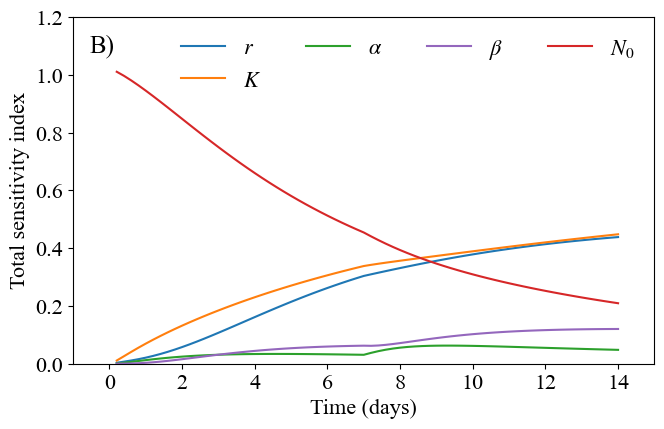

In [6]:
# Define the parameters to calibrate and the number of parameters
parameters_to_calibrate = ['$r$', '$K$', '$\\alpha$', '$\\beta$', '$N_0$']

number_of_parameters = len(parameters_to_calibrate)

# Generate random samples for sensitivity analysis
A, B, C = generate_samples(parameters=number_of_parameters, samples=1000)

# Define the time step and time range for the simulation
time_step = 0.2
time_range = np.arange(0, 14 + 0.5 * time_step, time_step)

# Specify treatment days
treatment_days = [0, 7]

# Run sensitivity analysis to obtain simulation results
solA, solB, solC = run_sensitivity_analysis(A, B, C, time_range, treatment_days)

# Analyze sensitivity results and calculate temporal sensitivity indices
temporal_sa = analyze_results(solA, solC)

# Plot sensitivity analysis results over time
plot_sensitivity(time_range, temporal_sa, number_of_parameters, parameters_to_calibrate)

# Perform convergence analysis and obtain convergence results
#convergence_sa = convergence_results(solA, solC)

# Plot sensitivity convergence analysis over the number of samples
#plot_convergence(convergence_sa, number_of_parameters, parameters_to_calibrate)